### Enhancing Topic Modeling with Contextualized Representations (BERT Embeddings)
In this section, I am going to use Sentence Transformers to generate embeddings for the content. To make the embeddings suitable for clustering I will recduce their dimensionality using PCA and then cluster the reduced embeddings using K-means to identify topics. 

In [1]:
import pandas as pd

# Let's load the preprocessed dataset
file_path = 'data/preprocessed_guardian_editorials_data.csv'
data = pd.read_csv(file_path)

# And check the first few rows
print("Dataset Preview:")
print(data.head())

Dataset Preview:
         date_of_publication  \
0  2024-11-30 19:30:34+00:00   
1  2024-11-30 19:00:33+00:00   
2  2024-11-30 18:00:33+00:00   
3  2024-11-30 17:00:31+00:00   
4  2024-11-30 16:00:32+00:00   

                                            headline  \
0  the observer view shaky ceasefire is no victor...   
1  the observer view ignore the stigma and tackle...   
2  wicked would be fun and forgettable but for th...   
3  feeding off anger fuelled by russia enter clin...   
4  what connects huddersfields s football stadium...   

                                             content  headline_length  \
0  for the people of lebanon last weeks agreement...               98   
1  i wanted them all to notice this is the title ...               85   
2  the war on woke has a new target and her name ...               85   
3  politics in romania can be a bloody business e...               93   
4   was a vintage year for architecture the years...               74   

   content_len

#### Data Cleaning and Pre-processing

In [2]:
import re
import spacy

# Like we did some cleaning before the BoW representation
# Let's Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function to clean and lemmatize text
def clean_and_lemmatize(text):
    # Remove non-alphabetic characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Lemmatize using spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Apply cleaning to the content column
print("Cleaning and lemmatizing text...")
data['content'] = data['content'].apply(clean_and_lemmatize)

Cleaning and lemmatizing text...


#### Generate BERT Embeddings

In [3]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Now let's load a pre-trained BERT-based model from Sentence Transformers
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight BERT model for embeddings

# And, generate embeddings for the editorial content
print("Generating BERT embeddings...")
data['bert_embeddings'] = data['content'].apply(lambda x: model.encode(str(x)))

# And, convert embeddings to a matrix
bert_embedding_matrix = np.vstack(data['bert_embeddings'].values)

# Also let's save the embeddings
np.save('data/bert_embedding_matrix.npy', bert_embedding_matrix)
print("BERT embeddings saved to 'data/bert_embedding_matrix.npy'")

C:\Users\adity\miniconda3\envs\nlp\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating BERT embeddings...
BERT embeddings saved to 'data/bert_embedding_matrix.npy'


#### Dimesionality Reduction with PCA

In [4]:
from sklearn.decomposition import PCA

# Now let's reduce embeddings to 50 dimensions for topic modeling
print("Reducing embeddings to 50 dimensions using PCA...")
pca = PCA(n_components=50, random_state=42)
reduced_embeddings = pca.fit_transform(bert_embedding_matrix)

# And, save the reduced embeddings
np.save('data/reduced_embeddings.npy', reduced_embeddings)
print("Reduced embeddings saved to 'data/reduced_embeddings.npy'")

Reducing embeddings to 50 dimensions using PCA...
Reduced embeddings saved to 'data/reduced_embeddings.npy'


#### Topic Modeling with k-means

In [5]:
from sklearn.cluster import KMeans

# Now, let's define the number of topics
num_topics = 15

# And, apply K-Means clustering
print(f"Clustering into {num_topics} topics using K-Means...")
kmeans = KMeans(n_clusters=num_topics, random_state=42)
data['topic'] = kmeans.fit_predict(reduced_embeddings)

# And, save topic assignments
data.to_csv('data/guardian_editorials_with_topics.csv', index=False)
print("Topic assignments saved to 'data/guardian_editorials_with_topics.csv'.")


Clustering into 15 topics using K-Means...
Topic assignments saved to 'data/guardian_editorials_with_topics.csv'.


#### Extract the top words or sentences for each topic

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Now, let's get the cluster centroids
centroids = kmeans.cluster_centers_

# Now, let's find the nearest documents to each centroid
print("Finding top documents for each topic...")
top_documents = {}
for i, centroid in enumerate(centroids):
    similarities = cosine_similarity([centroid], reduced_embeddings)[0]
    top_doc_indices = similarities.argsort()[-10:][::-1]  # Top 10 documents
    top_documents[i] = data.iloc[top_doc_indices]['content'].tolist()

# And, display the top documents for each topic
for topic, docs in top_documents.items():
    print(f"\nTopic {topic}:")
    for doc in docs[:3]:  # Display the first 3 documents for brevity
        print(doc[:300])  # Print the first 300 characters of each document


Finding top documents for each topic...

Topic 0:
chair early pregnancy loss coalition thrilled federal budget announcement time miscarriage receive dedicated untied funding equally delighted funding endometriosis people experience endometriosis likely miscarriagep ppioneer like guardian australia journalist gabrielle jackson author seminal book pa
live control abusive partner parent know problem s prohibit unsure prohibit prospect punishment instill fear vagueness punish promote caution case teenager not hang certain friend teacher delete controversial book curriculump pthe doctor decide perform abortion patient health life risk maybe imminen
doctor obligation federal law patient alive patient happen pregnant woman doctor obligation prevent maiming irreversible organ damage kind bodily harm obligation extend woman woman right access medically necessary care pregnant accord fifth circuit courtp pthat hrefhttpsstoragecourtlistenercomrecapg

Topic 1:
book hrefhttpsabetternhsnetinpainspre

#### Visualize the Topics

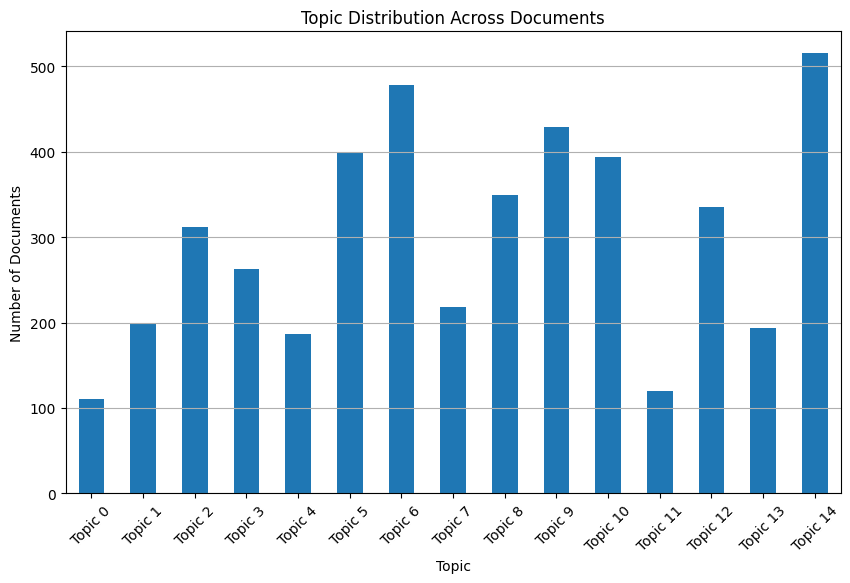

In [7]:
import matplotlib.pyplot as plt

# Plot topic distribution
topic_counts = data['topic'].value_counts()
topic_counts.sort_index().plot(kind='bar', figsize=(10, 6))
plt.title("Topic Distribution Across Documents")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.xticks(range(num_topics), [f"Topic {i}" for i in range(num_topics)], rotation=45)
plt.grid(axis='y')
plt.show()

Generating word clouds for topics...


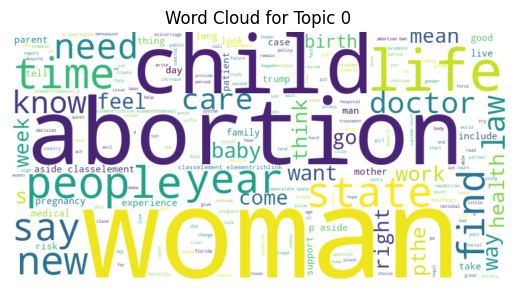

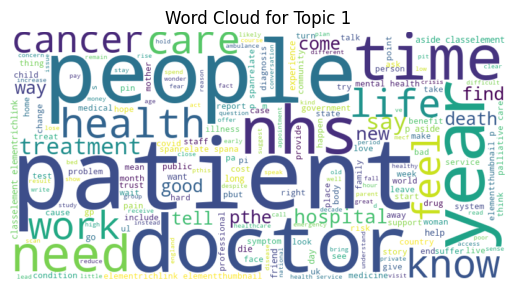

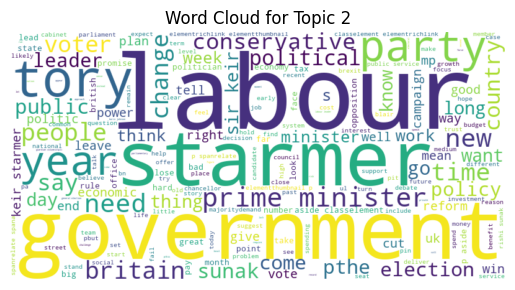

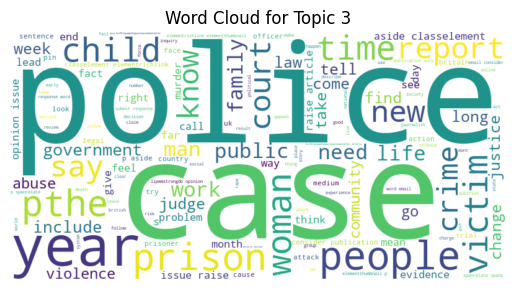

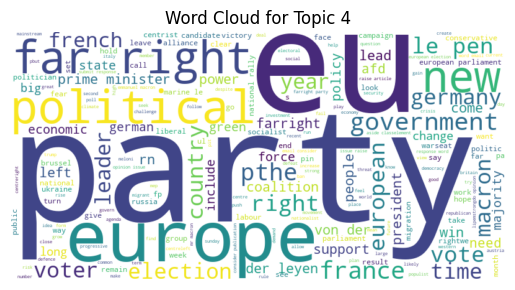

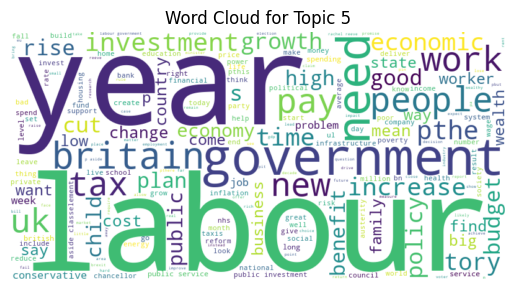

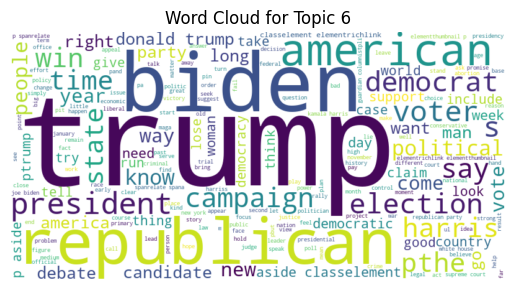

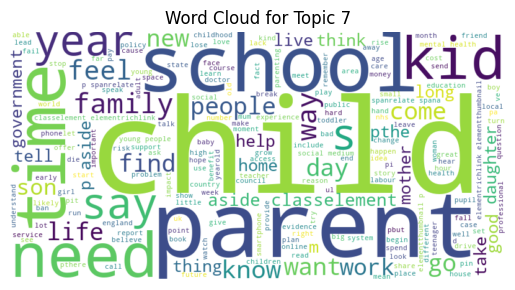

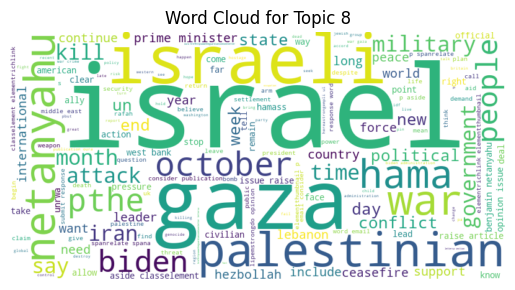

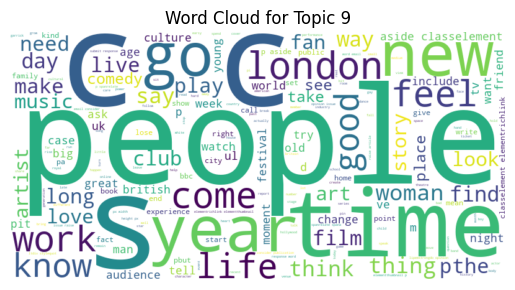

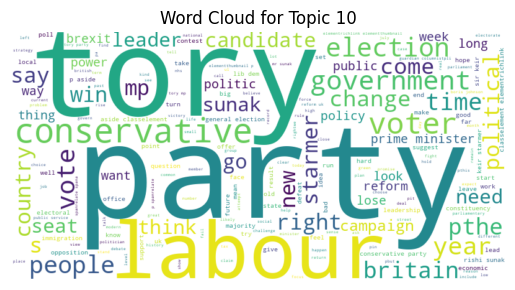

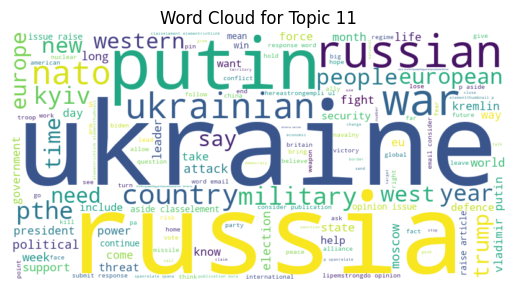

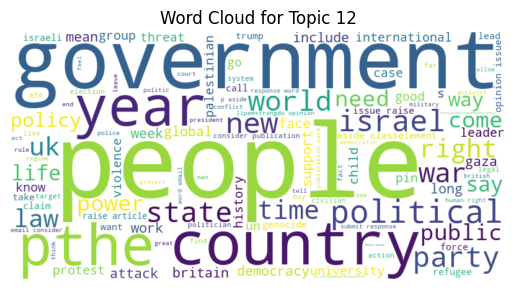

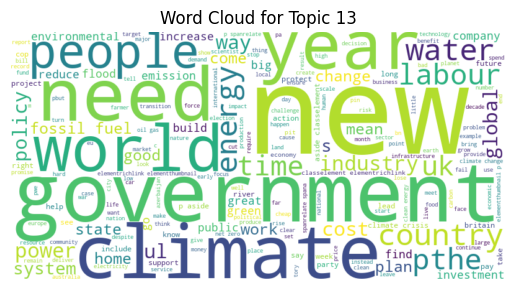

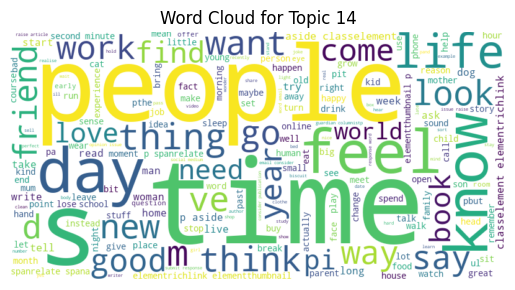

In [8]:
from wordcloud import WordCloud

# Generate word clouds for each topic
print("Generating word clouds for topics...")
for topic_idx, centroid in enumerate(centroids):
    similarities = cosine_similarity([centroid], reduced_embeddings)[0]
    top_doc_indices = similarities.argsort()[-100:][::-1]  # Top 100 documents
    combined_text = ' '.join(data.iloc[top_doc_indices]['content'].values)
    
    # Create the word cloud
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(combined_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()

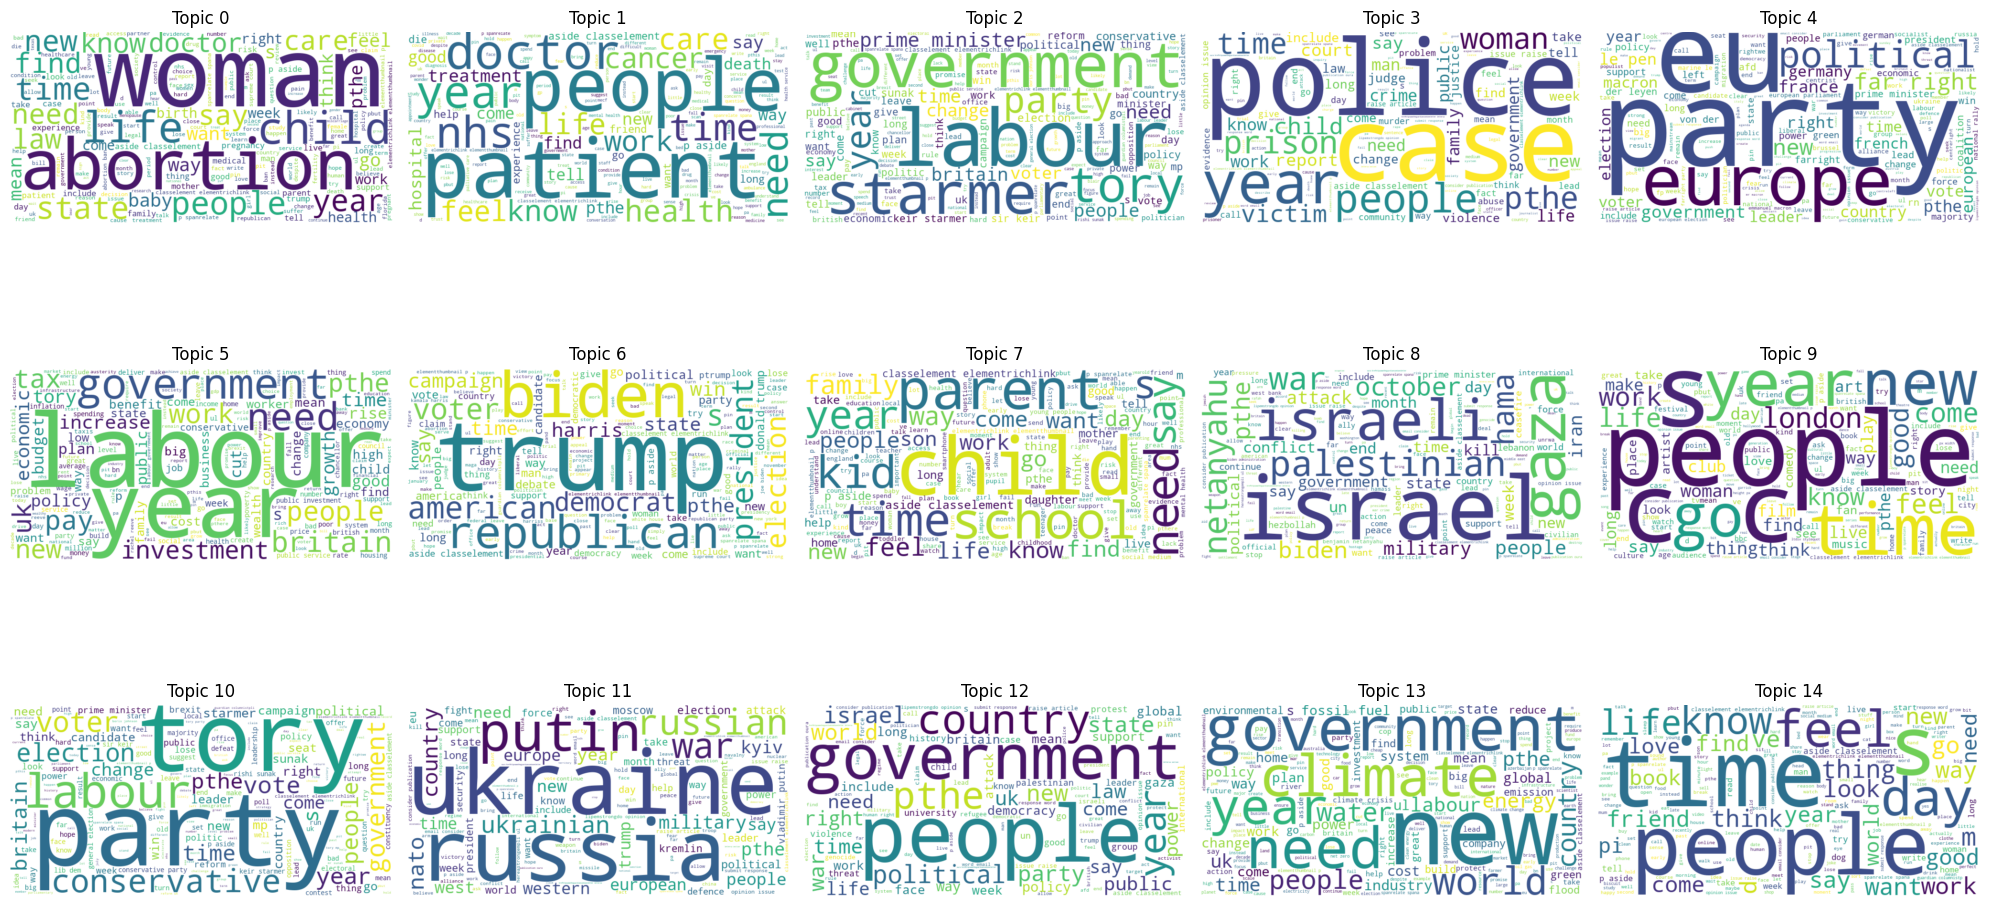

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Define the number of topics
num_topics = len(centroids)  # Number of clusters from BERT embeddings

# Initialize the grid layout
ncols = 5  # Number of columns in the grid
nrows = (num_topics // ncols) + (num_topics % ncols > 0)  # Calculate rows based on topics
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))  # Adjust figure size
# fig.suptitle("Word Clouds for All Topics - BERT Embeddings", fontsize=24)

# Generate word clouds for each topic and plot them
for topic_idx, centroid in enumerate(centroids):
    row, col = divmod(topic_idx, ncols)  # Determine row and column in grid
    ax = axes[row, col] if nrows > 1 else axes[col]  # Adjust for 1-row case
    
    # Get the top 100 documents for the topic
    similarities = cosine_similarity([centroid], reduced_embeddings)[0]
    top_doc_indices = similarities.argsort()[-100:][::-1]  # Top 100 documents
    combined_text = ' '.join(data.iloc[top_doc_indices]['content'].values)
    
    # Create and plot the word cloud
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(combined_text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Topic {topic_idx}", fontsize=12)

# Remove empty subplots (if any)
for idx in range(num_topics, nrows * ncols):
    fig.delaxes(axes.flatten()[idx])  # Remove extra axes

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.savefig("word_clouds_all_topics_bert.png", dpi=300)  # Save as a single image
plt.show()